This post looks at two things:

1. Supplying your own parameters when normalizing molecules using the RDKit's `MolStandardize`
2. Capturing and parsig the RDKit's C++ logs from within Python

The RDKit's `MolStandardize` module includes functionality for "normalizing" input molecules: applying a set of chemical transformations expressed as reactions to standardize the representation of particular functional groups or substructures of the input molecule. This kind of normalization is a common step in preparing molecules for a compound registration system. `MolStandardize` has a collection of default transformations adapted from Matt Swain's [MolVS](https://molvs.readthedocs.io/en/latest/) (`MolStandardize` itself started as a C++ port of MolVS) which cover standardizing a variety of common functional groups. The full list is in the [RDKit source](https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/MolStandardize/TransformCatalog/normalizations.in).

Though we have tried to provide a broad and useful set of transformations, we know that they won't fit everybody's needs, so the `MolStandardize` allows the user to provide their own transformations. The first part of this post demonstrates how to do that.

The normalization funcationality in `MolStandarize` sends information about what transformations have been applied to the console using the RDKit's logging functionality. This can be useful when working with small numbers of molecules in the shell or a notebook, and when debugging new transformations, but quickly becomes irritating when working with larger sets of molecules. In the second part of the post I'll show how to disable this logging information as well as how to capture it and parse the logs to find out which transformations were applied to each molecule.



In [1]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import rdkit
print(rdkit.__version__)

2023.09.5


# Providing your own normalization transformations

Let's start with a simple molecule to demonstrate the default behavor of the normalization code.

The easiest way to apply the defaults to a molecule is to use the function `rdMolStandardize.Normalize()`:

[05:54:00] Initializing Normalizer
[05:54:00] Running Normalizer
[05:54:00] Rule applied: Recombine 1,3-separated charges


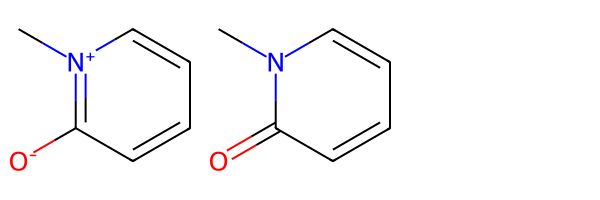

In [2]:
m = Chem.MolFromSmiles('[O-]c1[n+](C)cccc1')
m2 = rdMolStandardize.Normalize(m)
Draw.MolsToGridImage([m,m2])

An aside: as was mentioned in [another recent blog post](https://greglandrum.github.io/rdkit-blog/posts/2024-02-11-more-multithreading.html), it's possible to call `NormalizeInPlace()` to modify the molecule in place instead of making a copy and working on it. This will be a bit faster and can be used with mulitiple threads when working with more than one molecule.

We can accomplish the same thing by creating a `Normalizer` object and using it to normalize the molecule:

[05:54:01] Initializing Normalizer
[05:54:01] Running Normalizer
[05:54:01] Rule applied: Recombine 1,3-separated charges


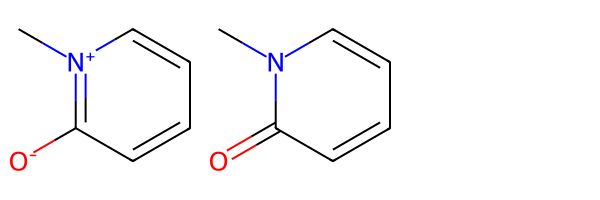

In [3]:
nrm = rdMolStandardize.Normalizer()
m2 = nrm.normalize(m)
Draw.MolsToGridImage([m,m2])

Now let's look at another molecule where the normalization doesn't do anything:

[05:54:02] Running Normalizer


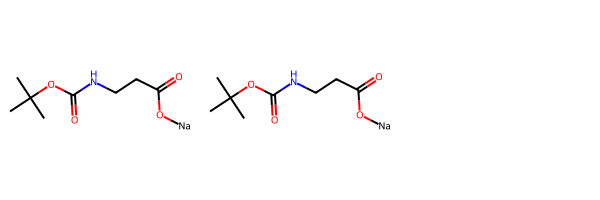

In [4]:
m = Chem.MolFromSmiles('CC(C)(C)OC(=O)NCCC(=O)O[Na]')
m2 = nrm.normalize(m)
Draw.MolsToGridImage([m,m2])

As a demonstration, let's construct a normalizer which will break the bond to the alkali metal and remove the Boc protecting group. This is, of course, an artificial example, but it shows how to provide new transformations to `MolStandardize`

[05:54:08] Initializing Normalizer
[05:54:08] Running Normalizer
[05:54:08] Rule applied: remove_Boc
[05:54:08] Rule applied: disconnect_alkali_metals


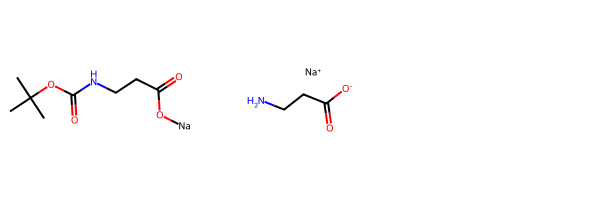

In [5]:
# we provide the transformations in a string with one line per transformation.
# Lines starting with // are comments and are ignored. Each line contains the
# name of the transformation, a tab character, and then the reaction SMARTS for
# the transformation itself. It's also possible to skip the names; in that case
# just provide the reaction SMARTS (the tab is not needed)
tfs = '''
// this is from Deprotect.cpp:
remove_Boc\t[C;R0][C;R0]([C;R0])([O;R0][C;R0](=[O;R0])[NX3;H0,H1:1])C>>[N:1]
// this should go last, because later transformations will
// lose the alkali metal
disconnect_alkali_metals\t[Li,Na,K,Rb:1]-[A:2]>>([*+:1].[*-:2])
'''
# create the new Normalizer:
cps = rdMolStandardize.CleanupParameters()
nrm2 = rdMolStandardize.NormalizerFromData(tfs,cps)

# and apply it:
m2 = nrm2.normalize(m)
Draw.MolsToGridImage([m,m2])

If you're processing a lot of molecules, you probably don't want those log messages filling your console or notebook. It's possible to disable the logging:

In [7]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
m2 = nrm2.normalize(m)


# Connecting the RDKit logs to the Python logger

It's also possible to have the logging the RDKit's C++ backend does sent to Python's built-in logging facilities. This has been available since the 2022.03.1 release of the RDKit.

I won't do a complete introduction to Python's logging capabilities here (I'm not an expert!), but here's a quick demonstration of what we might do:

In [19]:
import logging

logger = logging.getLogger('rdkit')
# set the log level for the default log handler (the one which sense output to the console/notebook):
logger.handlers[0].setLevel(logging.WARN)
# format the messages so that it's clear they come from the RDKit:
logger.handlers[0].setFormatter(logging.Formatter('[RDKit] %(levelname)s:%(message)s'))

# Tell the RDKit's C++ backend to log to use the python logger:
from rdkit import rdBase
rdBase.LogToPythonLogger()


Now do something which generates an error message:

In [20]:
Chem.MolFromSmiles('C1C')

[RDKit] ERROR:[06:18:05] SMILES Parse Error: unclosed ring for input: 'C1C'


You can tell that this went through the Python logger because it has the prefix we set up above.

Since we're only logging at the WARN (and above) level, the INFO messages from doing normalizations don't appear:

In [21]:
m2 = nrm2.normalize(m)

Let's create an additional log message handler that catches INFO messages too but that saves them in a `StringIO` object instead of outputting them to the console:

In [38]:
from io import StringIO

logger_sio = StringIO()
# create a handler that uses the StringIO and set its log level:
handler = logging.StreamHandler(logger_sio)
handler.setLevel(logging.INFO)

# add the handler to the Python logger:
logger.addHandler(handler)

# we also need to change the level of the main logger so that the INFO messages get sent to the handlers:
logger.setLevel(logging.INFO)

Now normalize a molecule:

In [39]:
m2 = nrm2.normalize(m)

We don't see anything in the notebook because the main handler (the one which goes to the console/notebook) is still set to only show WARN and above, but `logger_sio` has the message:

In [40]:
text = logger_sio.getvalue()
print(text)

[06:20:44] Running Normalizer
[06:20:44] Rule applied: remove_Boc
[06:20:44] Rule applied: disconnect_alkali_metals



We can use a regular expression to extract the rules that were applied to the molecule from this output:

In [41]:
import re
rules = re.findall(r'Rule applied: (.*?)\n',text)
rules

['remove_Boc', 'disconnect_alkali_metals']

If we now sanitize another molecule (or, in this case, the same one again), the log messages are appended to `logger_sio`:

In [42]:
m2 = nrm2.normalize(m)

In [43]:
text = logger_sio.getvalue()
print(text)

[06:20:44] Running Normalizer
[06:20:44] Rule applied: remove_Boc
[06:20:44] Rule applied: disconnect_alkali_metals
[15:22:05] Running Normalizer
[15:22:05] Rule applied: remove_Boc
[15:22:05] Rule applied: disconnect_alkali_metals



But we can reset the StringIO object:

In [45]:
logger_sio.truncate(0)
logger_sio.seek(0)

# Create and normalize a new molecule:
new_m = Chem.MolFromSmiles('CCCO[Na]')
new_m2 = nrm2.normalize(new_m)

# show the normalizations that were applied:
re.findall(r'Rule applied: (.*?)\n',logger_sio.getvalue())

['disconnect_alkali_metals']

We can now combine everything to write a function which applies a collection of custom transformations to a list of molecules and returns the transformed molecules along with which transformations were applied to each molecule:

In [46]:
import logging
from io import StringIO
from rdkit import rdBase
import re

def normalize_molecules(mols,standardization_rules):
    # Tell the RDKit's C++ backend to log to use the python logger:
    rdBase.LogToPythonLogger()

    logger = logging.getLogger('rdkit')
    # set the log level for the default log handler (the one which sense output to the console/notebook):
    logger.handlers[0].setLevel(logging.WARN)

    logger_sio = StringIO()
    # create a handler that uses the StringIO and set its log level:
    handler = logging.StreamHandler(logger_sio)
    handler.setLevel(logging.INFO)
    # add the handler to the Python logger:
    logger.addHandler(handler)

    
    # create the new Normalizer:
    cps = rdMolStandardize.CleanupParameters()
    nrm = rdMolStandardize.NormalizerFromData(standardization_rules,cps)

    match_expr = re.compile(r'Rule applied: (.*?)\n')
    
    res_mols = []
    tfs_applied = []
    for mol in mols:
        mol = nrm.normalize(mol)
        res_mols.append(mol)
        
        text = logger_sio.getvalue()
        tfs_applied.append(match_expr.findall(text))
        
        logger_sio.truncate(0)
        logger_sio.seek(0)

    return res_mols,tfs_applied

    
    

In [49]:
tfs = '''
// this is from Deprotect.cpp:
remove_Boc\t[C;R0][C;R0]([C;R0])([O;R0][C;R0](=[O;R0])[NX3;H0,H1:1])C>>[N:1]
// this should go last, because later transformations will
// lose the alkali metal
disconnect_alkali_metals\t[Li,Na,K,Rb:1]-[A:2]>>([*+:1].[*-:2])
'''

mols = [Chem.MolFromSmiles(smi) for smi in 
        ('CC(C)(C)OC(=O)NCCC(=O)O[Na]','CCCO[Na]','CC(C)(C)OC(=O)NCCC','c1ccccc1')]
tmols,tapplied = normalize_molecules(mols,tfs)

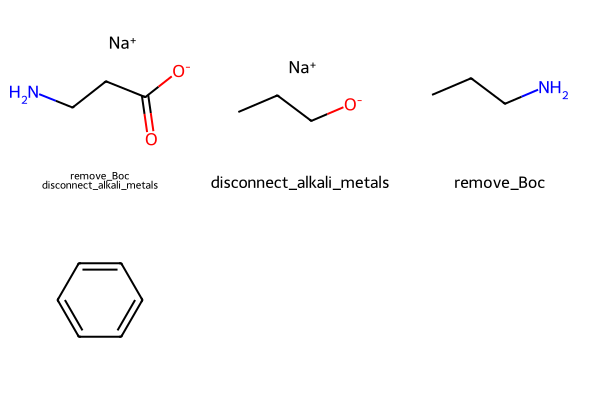

In [53]:
Draw.MolsToGridImage(tmols,legends=['\n'.join(x) for x in tapplied])